## Demo of Kolmogorov flow solver using JAX with coarse grid

#### Ensure JAX is using GPU for optimal performance

In [1]:
import jax

def check_jax_device():
    from jax.lib import xla_bridge
    device = xla_bridge.get_backend().platform
    print(f"JAX is using: {device}")

check_jax_device()

JAX is using: gpu


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from solvers import transient
from equations.flow import FlowConfig 
import equations.base as base
import equations.utils as utils 

In [3]:
flow = FlowConfig()

# Physical parameters 
flow.Re = 1500
flow.k = 4

dt = 0.0001
grid = flow.create_fft_mesh()
omega_0 = flow.initialize_state()
vorticity_hat0 = omega_0

# Underlying equation
equation = base.PseudoSpectralNavierStokes2D(flow)

# Timing
end_time = 100
# Save every x seconds 
save_time = 0.5
total_steps = int(end_time // dt)
step_to_save = int(save_time // dt) 

step_fn = transient.RK4_CN(equation, dt)
_, trajectory = transient.iterative_func(step_fn, vorticity_hat0, total_steps, step_to_save)
jnp.save('kolmogorov_coarse_Re_{}'.format(flow.Re), trajectory)


2024-07-10 01:04:07.457476: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Visualize and create animation

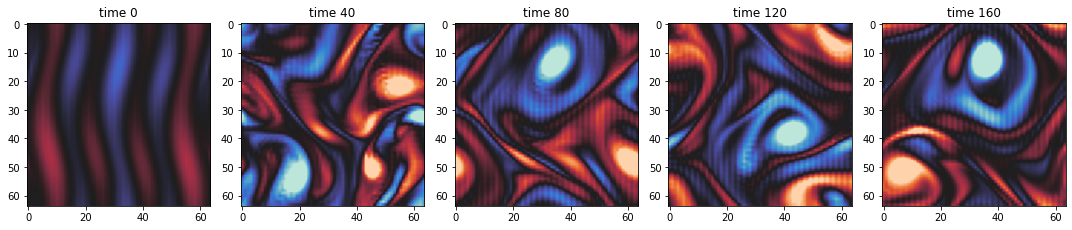

In [5]:
cols = 5
fig, axs = plt.subplots(1, cols, figsize=(15, 5))

vorticity = jnp.load('kolmogorov_coarse_Re_{}.npy'.format(flow.Re))
ifft_vorticity = jnp.fft.irfftn(vorticity, axes=(1,2))

for i in range(cols):
    time = int(len(ifft_vorticity) * (i/cols))
    axs[i].imshow(ifft_vorticity[time], cmap='icefire', vmin=-8, vmax=8)
    axs[i].set_title('time {}'.format(time))

plt.tight_layout()
plt.show()

### Create animation

In [ ]:
utils.create_animation('kolmogorov_coarse_Re_{}.npy'.format(flow.Re), 'coarse_gif', 0.06)

### Demonstrate mass conservation

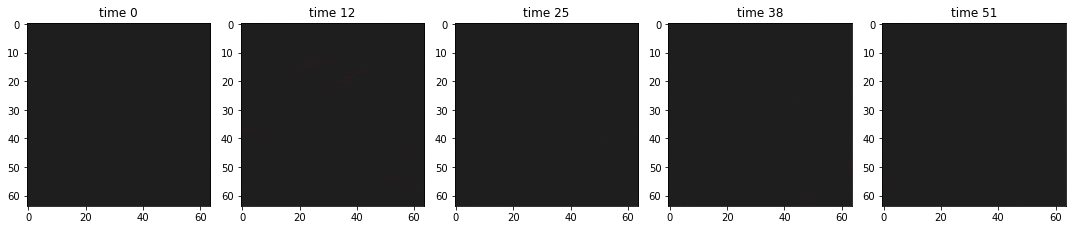

In [8]:
cols = 5
fig, axs = plt.subplots(1, cols, figsize=(15, 5))
flow = FlowConfig()
simulation = jnp.load('kolmogorov_coarse_Re_1500.npy')

data = jnp.fft.irfftn(simulation, axes=(1,2))
kx, ky = flow.create_fft_mesh()

for i in range(cols):
    time = int(len(data) * (i/cols))
    data = utils.compute_divergence(simulation[time], kx, ky)
    axs[i].imshow(data, cmap='icefire', vmin=-1, vmax=1)
    axs[i].set_title('time {}'.format(time))

plt.tight_layout()
plt.show()
